# Setup

In [1]:
from consav.runtools import write_numba_config
write_numba_config(disable=0,threads=20,threading_layer='omp')

In [2]:
import os
import time
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
colors = [x['color'] for x in plt.style.library['seaborn']['axes.prop_cycle']]
markers = ['s','P','D','v','^','*']

from consav.misc import elapsed
from TwoAssetModelCont import TwoAssetModelContClass

In [3]:
LOAD_HANK = True
LOAD = True

# Calibration function

In [4]:
def setup_calibration(model):
    
    par = model.par
    
    # a. targets
    model.targets = {}
    model.targets['AY'] = 2.92
    model.targets['BY'] = 0.26
    model.targets[('frac_b0_a0','baseline')] = 0.10
    model.targets[('frac_b0_apos','baseline')] = 0.20
    model.targets[('frac_bneg','baseline')] = 0.15
    
    model.labels = {}
    model.labels['AY'] = 'capital/output'
    model.labels['BY'] = 'bond/output'
    model.labels[('frac_b0_a0','baseline')] = 'poor HtM'
    model.labels[('frac_b0_apos','baseline')] = 'wealthy HtM'
    model.labels[('frac_bneg','baseline')] = 'borrowers'
    
    # b. parameters
    model.names = ['kappa','kappa0','kappa1','kappa2','rho','Pi']
    model.specs = {}
    model.specs['kappa'] = {'initial':par.kappa,'lower':0,'upper':0.1,'label':'$\\kappa$'}
    model.specs['kappa0'] = {'initial':par.kappa0,'lower':0,'upper':0.1,'label':'$\\kappa_0$'}
    model.specs['kappa1'] = {'initial':par.kappa1,'lower':0,'upper':1,'label':'$\\kappa_1$'}
    model.specs['kappa2'] = {'initial':par.kappa2,'lower':0.1,'upper':2.0,'label':'$\\kappa_2$'}
    model.specs['rho'] = {'initial':par.rho,'lower':0.01,'upper':0.02,'label':'$\\rho$'}
    model.specs['Pi'] = {'initial':par.Pi,'lower':0.01,'upper':0.50,'label':'$\\Pi$'}

    # c. update func
    def extra_update(model):

        par = model.par

        # a. KY and KN
        AY = model['AY']
        a = -par.delta*par.vareps
        b = par.alpha*(par.vareps-1) + par.delta*par.vareps*AY+par.omega
        c = -par.alpha*(par.vareps-1)*AY    
        KY = (-b+np.sqrt(b**2-4*a*c))/(2*a)
        KN = KY**(1/(1-par.alpha))

        # b. factor prices
        par.ra = par.alpha*m/(KN**(1-par.alpha)) - par.delta
        par.w = (1-par.alpha)*m*KN**par.alpha

        # c. set relative parameters
        Y = par.Pi*par.vareps
        par.kappa3 = 0.02*Y # 2 percent of quarterly GDP
        par.lumpsum_transfer = 0.10*Y # 10 percent of quarterly GDP
        par.b_min = -1*par.w # 1 times quarterly labor income

    model.extra_update = extra_update

# HANK calibration

In [5]:
if LOAD_HANK and os.path.isfile(f'data\HANK_calibration_UMFPACK_par.p'):
    HANK = TwoAssetModelContClass(name='HANK_calibration',load=True)
    setup_calibration(HANK)
    HANK.calculate_moments(do_MPC=True)
else:
    HANK = TwoAssetModelContClass(name='HANK_calibration')
    setup_calibration(HANK)
    HANK.calibrate()
    HANK.save()

In [6]:
HANK.show_moments()

Equilibrium objects:
 rb: 0.0050
 ra: 0.0142
 w: 1.814
 Pi: 0.174
 capital-labor discrepancy: 0.00044345
 profit discrepancy: -0.00000432

Aggregates:
 GDP: 1.739
 capital-labor ratio: 28.153
 capital-output ratio: 2.339
 bond-output ratio: 0.232

Fractions:
 poor HtM: 0.101 [0.101, 0.145]
 wealthy HtM: 0.185 [0.185, 0.283]
 borrowers: 0.143 [0.143, 0.129]

Iliquid wealth:
 top   0.1: 0.071
 top     1: 0.405
 top    10: 0.875
 bottom 50: 0.001
 bottom 25: 0.000
 gini: 0.819

Liquid wealth:
 top   0.1: 0.024
 top     1: 0.182
 top    10: 0.749
 bottom 50: -0.031
 bottom 25: -0.031
 gini: 0.860

MPC: 0.157
Consumption: avarage = 1.147, gini = 0.311
Value: avarage = -18.902


# Calibration with dense grids

In [7]:
if LOAD and os.path.isfile(f'data\calibration_UMFPACK_par.p'):

    model = TwoAssetModelContClass(name='calibration',load=True)
    setup_calibration(model)
    model.calculate_moments(do_MPC=True)
    
else:
    
    # a. setup
    model = TwoAssetModelContClass(name='calibration')

    # b. denser grids
    model.par.Na = 200
    model.par.Nb_neg = 30
    model.par.Nb_pos = 60

    # c. calibrate
    setup_calibration(model)
    model.calibrate()
    
    # e. save
    model.save()

In [8]:
model.show_moments()

Equilibrium objects:
 rb: 0.0050
 ra: 0.0142
 w: 1.814
 Pi: 0.173
 capital-labor discrepancy: -0.00042899
 profit discrepancy: 0.00018067

Aggregates:
 GDP: 1.728
 capital-labor ratio: 28.177
 capital-output ratio: 2.341
 bond-output ratio: 0.185

Fractions:
 poor HtM: 0.002 [0.135, 0.146]
 wealthy HtM: 0.261 [0.231, 0.289]
 borrowers: 0.341 [0.245, 0.184]

Iliquid wealth:
 top   0.1: 0.065
 top     1: 0.304
 top    10: 0.826
 bottom 50: 0.001
 bottom 25: 0.000
 gini: 0.873

Liquid wealth:
 top   0.1: 0.028
 top     1: 0.198
 top    10: 0.781
 bottom 50: -0.052
 bottom 25: -0.052
 gini: 0.917

MPC: 0.170
Consumption: avarage = 1.135, gini = 0.298
Value: avarage = -16.776


## Compare parameters

In [9]:
for name in model.names:
    
    print(name)
    print(f'     HANK: {getattr(HANK.par,name):.8f}')
    print(f' baseline: {getattr(model.par,name):.8f}')

kappa
     HANK: 0.01520333
 baseline: 0.01476019
kappa0
     HANK: 0.04320631
 baseline: 0.04504896
kappa1
     HANK: 0.48085145
 baseline: 0.47002145
kappa2
     HANK: 0.40539251
 baseline: 0.39534711
rho
     HANK: 0.01273509
 baseline: 0.01354950
Pi
     HANK: 0.17389044
 baseline: 0.17279941


# Comparisons

**Model labels:**

In [10]:
HANK.label = 'HANK'
model.label = 'dense'

**Calbiration results:**

In [11]:
with open(f'figs\\calibration_results_pars.tex','w') as file:
    
    file.write(f'\\begin{{tabular}}{{lcc}} \n')
    file.write(f'\\toprule \n')
    file.write(f'Parameter')    
    for m in [HANK,model]:
        file.write(f' & {m.label}')        
    file.write('\\\\\n')
    file.write('\\midrule \n')
    
    for name in HANK.names:
        file.write(f' {HANK.specs[name]["label"]} & {getattr(HANK.par,name):.4f} & {getattr(model.par,name):.4f} \\\\ \n')
    
    file.write('\\bottomrule\n')
    file.write('\\end{tabular}\n')

In [12]:
with open(f'figs\\calibration_results_moms.tex','w') as file:
    
    file.write(f'\\begin{{tabular}}{{lcc}} \n')
    file.write(f'\\toprule \n')
      
    file.write(f'Moment')    
    for m in [HANK,model]:
        file.write(f' & {m.label}')        
    file.write('\\\\ \n')
    file.write('\\midrule \n')
    
    for key in HANK.targets.keys():
        file.write(f' {HANK.labels[key]} & {HANK.moms[key]:.4f} & {model.moms[key]:.4f} \\\\ \n')
    
    file.write('\\bottomrule\n')
    file.write('\\end{tabular}\n')

## Adjustment costs

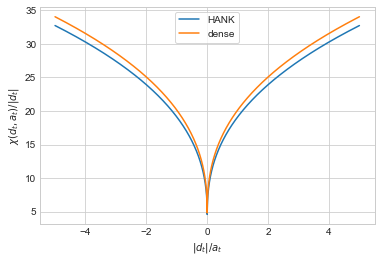

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for m in [HANK,model]:
    
    par = m.par
    
    # a. get chic
    chi_0 = par.kappa0
    chi_1 = par.kappa1**(-par.kappa2)/(1+par.kappa2)
    chi_2 = 1+par.kappa2

    # b. adjcost share
    adjcost_share =  lambda x: chi_0 + chi_1*abs(x)**(chi_2-1)

    # c. figure
    x = np.linspace(-0.05,0.05,100000)
    y = adjcost_share(x)
    ax.plot(x*100,y*100,label=m.label)
    
ax.set_xlabel('$|d_t|/a_t$')
ax.set_ylabel('$\chi(d_t,a_t)/|d_t|$')

ax.legend(loc='upper center',frameon=True)    
fig.savefig(f'figs/adjcost_compare.pdf')

## Distributions

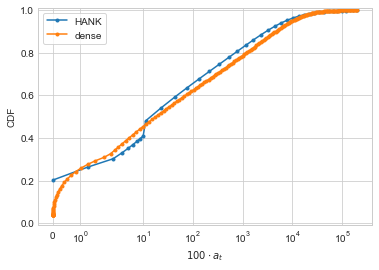

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xscale('symlog')

for m in [HANK,model]:
    ax.plot(m.par.grid_a*100,m.moms['a_margcum'],'-o',ms=3,label=m.label)   
    
ax.set_xlabel('$100 \cdot a_t$')
ax.set_ylabel(f'CDF')
ax.set_ylim([-0.01,1.01])
ax.legend(frameon=True)
    
fig.savefig(f'figs/CDF_a_compare.pdf')

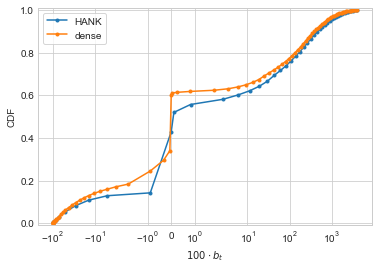

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xscale('symlog')

for m in [HANK,model]:
    ax.plot(m.par.grid_b*100,m.moms['b_margcum'],'-o',ms=3,label=m.label)   
    
ax.set_xlabel('$100 \cdot b_t$')
ax.set_ylabel(f'CDF')
ax.set_ylim([-0.01,1.01])
ax.legend(frameon=True)
    
fig.savefig(f'figs/CDF_b_compare.pdf')

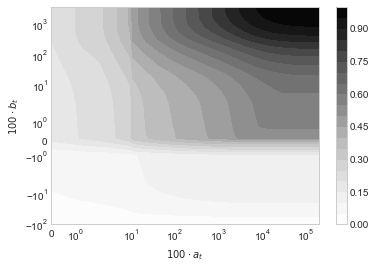

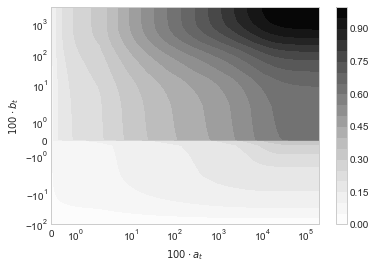

In [16]:
for m in [HANK,model]:
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    CS = ax.contourf(100*m.par.aaa[0],100*m.par.bbb[0],m.moms['ab_margcum'],levels=20)
    cbar = fig.colorbar(CS)

    ax.set_xlabel('$100 \cdot a_t$')
    ax.set_ylabel('$100 \cdot b_t$')
        
    fig.savefig(f'figs/CDF_ab_{m.label}.pdf')    

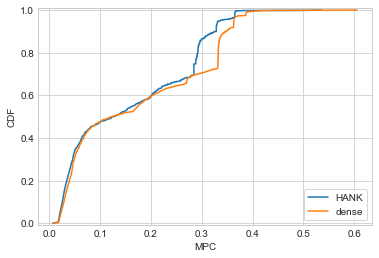

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for m in [HANK,model]:
    ax.plot(m.moms['grid_MPC'],m.moms['MPC_margcum'],'-',label=m.label)   
    
ax.set_xlabel('MPC')
ax.set_ylabel(f'CDF')
ax.set_ylim([-0.01,1.01])
ax.legend(loc='lower right',frameon=True)
    
fig.savefig(f'figs/CDF_MPC_compare.pdf')